# Constructing a BPF function
Create a boxcar 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

c:\Users\DELL\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [97]:
w = torch.linspace(0.1,2,41) # for plotting
polynomial_target = torch.zeros(len(w))
polynomial_target[int(0.25*len(w)):int(0.75*len(w))] = 1
def computeCurve(x,y,z):
    polynomial_w = x**2 + (y**2)*(w) + (z**2)*(w**2)
    return polynomial_w

def computeError(x,y,z):
    # return torch.sum(x**2 + (y**2)*(w) + (z**2)*(w**2))

    # polynomial_w = x**2 + (y**2)*(w) + (z**2)*(w**2)
    # return torch.sum(polynomial_w)

    polynomial_w = computeCurve(x,y,z)
    loss = nn.MSELoss()(polynomial_w, polynomial_target)
    return loss


Iteration 0 : (c0,c1,c2) = [0.5, 0.5, 0.5]; f = 12.942296028137207
Iteration 20 : (c0,c1,c2) = [0.11008310317993164, 0.35248109698295593, 0.4834945797920227]; f = 0.41297632455825806
Iteration 40 : (c0,c1,c2) = [0.5906112194061279, 0.37537670135498047, -0.03635095804929733]; f = 0.26282718777656555
Iteration 60 : (c0,c1,c2) = [0.684832751750946, 0.1471276581287384, -0.05883714184165001]; f = 0.2521376609802246
Iteration 80 : (c0,c1,c2) = [0.7046326994895935, 0.0478719100356102, 0.012041608802974224]; f = 0.2499135136604309


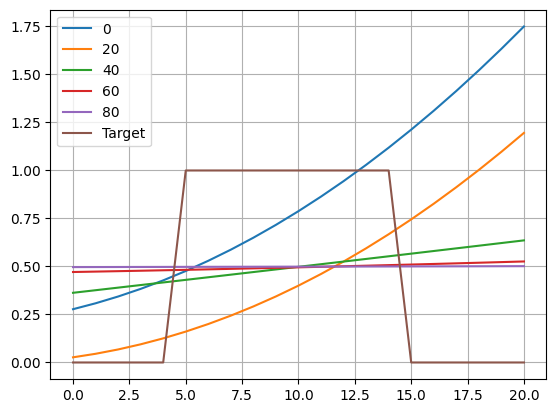

In [ ]:
c0 = torch.tensor(1.0, requires_grad=True)
c1 = torch.tensor(1.0, requires_grad=True)
c2 = torch.tensor(1.0, requires_grad=True)

fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([c0,c1,c2], lr=0.5) # Adaptive algorithm, better
for i in range(100):
    optimizer.zero_grad()
    # f = computeError(c0,c1,c2) 
    f = computeError(c0,c1,c2) 
    f.backward()
    optimizer.step()
    if(i%20==0):
        print(f'Iteration {i} : (c0,c1,c2) = {[_c.item() for _c in [c0,c1,c2]]}; f = {f.item()}')
        axes.plot(computeCurve(c0,c1,c2).detach().numpy())
        legend.append(i)
legend.append('Target')
axes.plot(polynomial_target)
axes.legend(legend)
axes.grid('on')

# WIP, matrices

C:\Users\DELL\AppData\Local\Temp\ipykernel_19380\3912534799.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1-(w**2)*L1*C1), torch.tensor(1j*w*L1)],
C:\Users\DELL\AppData\Local\Temp\ipykernel_19380\3912534799.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1j*w*C1), torch.ones(len(w))]
C:\Users\DELL\AppData\Local\Temp\ipykernel_19380\2937692610.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1-(w**2)*L1*C1), torch.tensor(1j*w*L1)],
C:\Users\DELL\AppData\Local\Temp\ipykernel_19380\2937

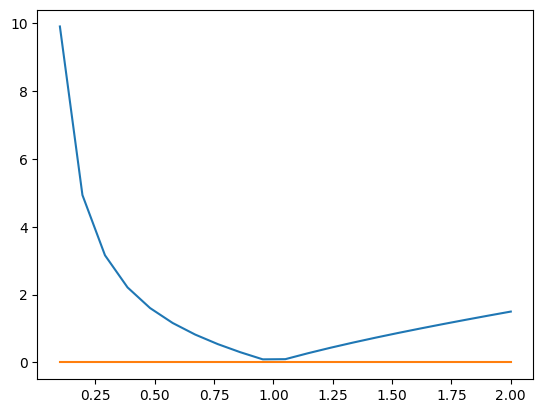

In [106]:
# parameters = torch.tensor(np.random.rand(2), requires_grad=True)
parameters = torch.tensor([1.0,1.0])
L1,C1 = parameters.detach().numpy()
M = [
    [torch.tensor(1-(w**2)*L1*C1), torch.tensor(1j*w*L1)],
    [torch.tensor(1j*w*C1), torch.ones(len(w))]
]

plt.plot(w,abs(M[0][0]/M[1][0])); plt.grid()
_temp = computeCurve(torch.tensor([1.0,1.0], requires_grad=True))
plt.plot(w,_temp); plt.grid()


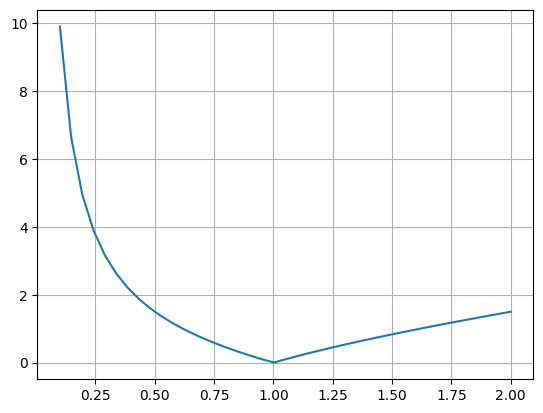

In [100]:
parameters = torch.tensor([1.0,1.0])
L1,C1 = parameters.detach().numpy()
_w = w.detach().numpy()
M = [
    [1-(_w**2)*L1*C1, 1j*_w*L1],
    [1j*_w*C1, 1]
]
M
# M[0][0]/M[1][0]
plt.plot(w,abs(M[0][0]/M[1][0])); plt.grid()

# WIP

In [126]:
w = torch.linspace(0.1,2,21) # for plotting
polynomial_target = torch.zeros(len(w))
polynomial_target[int(0.25*len(w)):int(0.75*len(w))] = 1

def computeCurve(parameters):
    # x, y, z = parameters
    # polynomial_w = x**2 + (y**2)*(w) + (z**2)*(w**2)
    
    # polynomial_w = parameters[0]**2 + (parameters[1]**2)*(w) + (parameters[2]**2)*(w**2)
    
    # polynomial_w = torch.zeros(len(w))
    # for _coeff,i in enumerate(parameters):
    #     polynomial_w += torch.zeros(len(w))#torch.tensor((_coeff**2)*(w**i))
        
    # polynomial_w = sum(c * w**i for i, c in enumerate(parameters))
    
    L1,C1 = parameters.detach().numpy()
    M = [
        [torch.tensor(1-(w**2)*L1*C1), torch.tensor(1j*w*L1)],
        [torch.tensor(1j*w*C1), torch.ones(len(w))]
    ]

    polynomial_w = M[0][0]/M[1][0] # for tensors, indexing like M[0,0] wont work

    return polynomial_w

def computeError(parameters):
    polynomial_w = computeCurve(parameters)
    loss = nn.MSELoss()(torch.abs(polynomial_w),torch.abs(polynomial_target))
    # loss = nn.MSELoss()(polynomial_w, polynomial_target)
    print('loss')
    print(loss)
    return loss


loss
tensor(25.2170)


C:\Users\DELL\AppData\Local\Temp\ipykernel_19380\1528292002.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1-(w**2)*L1*C1), torch.tensor(1j*w*L1)],
C:\Users\DELL\AppData\Local\Temp\ipykernel_19380\1528292002.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1j*w*C1), torch.ones(len(w))]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

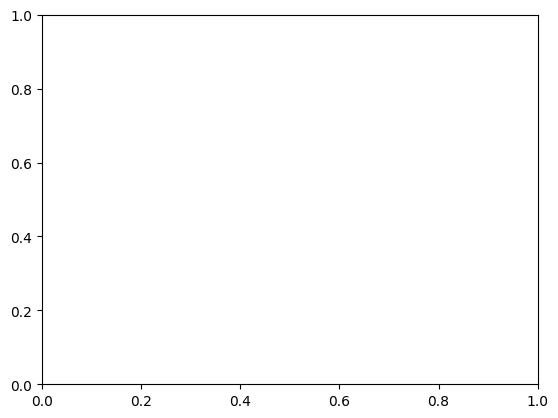

In [127]:

# =======================================================
# parameters = torch.tensor([1.0,2.0,3.0], requires_grad=True)
parameters = torch.tensor(np.random.rand(2), requires_grad=True)

fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([parameters], lr=0.5) # Adaptive algorithm, better
for i in range(100):
    optimizer.zero_grad()
    # f = computeError(c0,c1,c2) 
    f = computeError(parameters) 
    f.backward()
    optimizer.step()
    if(i%20==10):
        print(f'Iteration {i} : (c0,c1,c2) = {[_c.item() for _c in [c0,c1,c2]]}; f = {f.item()}')
        axes.plot(computeCurve(parameters).detach().numpy())
        legend.append(i)
legend.append('Target')
axes.plot(polynomial_target)
axes.legend(legend)
axes.grid('on')